In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms

mean, std = 0.28604059698879553, 0.35302424451492237
batch_size = 256

train_dataset = FashionMNIST('../data/FashionMNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = FashionMNIST('../data/FashionMNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

n_classes = 10

## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fashion_mnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
mnist_classes = fashion_mnist_classes

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Baseline: Classification with softmax
We'll train the model for classification and use outputs of penultimate layer as embeddings

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet
from metrics import AccumulatedAccuracyMetric

embedding_net = EmbeddingNet()
model = ClassificationNet(embedding_net, n_classes=n_classes)
if cuda:
    model.cuda()
loss_fn = torch.nn.NLLLoss()
lr = 1e-2
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 50

10000
28 28


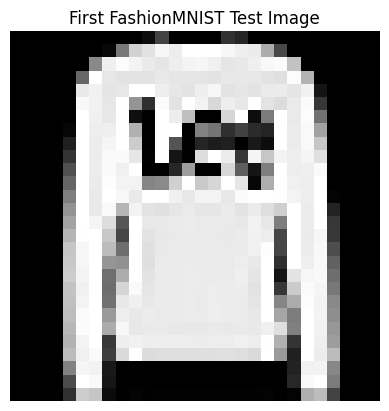

In [7]:
#display images for viewing
import gzip
import numpy as np
import matplotlib.pyplot as plt

# Path to the downloaded file
file_path = '../data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz'

# Read and parse the IDX file
with gzip.open(file_path, 'rb') as f:
    # Read magic number and dimensions (first 16 bytes)
    magic_number = int.from_bytes(f.read(4), byteorder='big')
    num_images = int.from_bytes(f.read(4), byteorder='big')
    num_rows = int.from_bytes(f.read(4), byteorder='big')
    num_cols = int.from_bytes(f.read(4), byteorder='big')

    print(num_images)
    print(num_rows,num_cols)

    # Read the image data
    image_data = np.frombuffer(f.read(), dtype=np.uint8)
    image_data = image_data.reshape(num_images, num_rows, num_cols)

# Show the first image
plt.imshow(image_data[1], cmap='gray')
plt.title("First FashionMNIST Test Image")
plt.axis('off')
plt.show()

In [5]:
fit(train_loader, test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AccumulatedAccuracyMetric()])

c:\Users\hwenjun\.conda\envs\deepcosegmentation\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Train: [0/60000 (0%)]	Loss: 2.381346	Accuracy: 8.984375
Train: [12800/60000 (21%)]	Loss: 2.964157	Accuracy: 15.770526960784315
Train: [25600/60000 (43%)]	Loss: 1.699070	Accuracy: 24.969059405940595
Train: [38400/60000 (64%)]	Loss: 1.268771	Accuracy: 34.50693294701987
Train: [51200/60000 (85%)]	Loss: 1.006448	Accuracy: 42.63254042288557
Epoch: 1/20. Train set: Average loss: 1.6086	Accuracy: 46.78333333333333
Epoch: 1/20. Validation set: Average loss: 0.8500	Accuracy: 73.31
Train: [0/60000 (0%)]	Loss: 0.876751	Accuracy: 78.515625
Train: [12800/60000 (21%)]	Loss: 0.771431	Accuracy: 74.08854166666667
Train: [25600/60000 (43%)]	Loss: 0.662891	Accuracy: 75.32874381188118
Train: [38400/60000 (64%)]	Loss: 0.633182	Accuracy: 75.88472682119205
Train: [51200/60000 (85%)]	Loss: 0.596321	Accuracy: 76.49448072139303
Epoch: 2/20. Train set: Average loss: 0.6536	Accuracy: 76.92666666666666
Epoch: 2/20. Validation set: Average loss: 0.5917	Accuracy: 79.18
Train: [0/60000 (0%)]	Loss: 0.517488	Accuracy: 

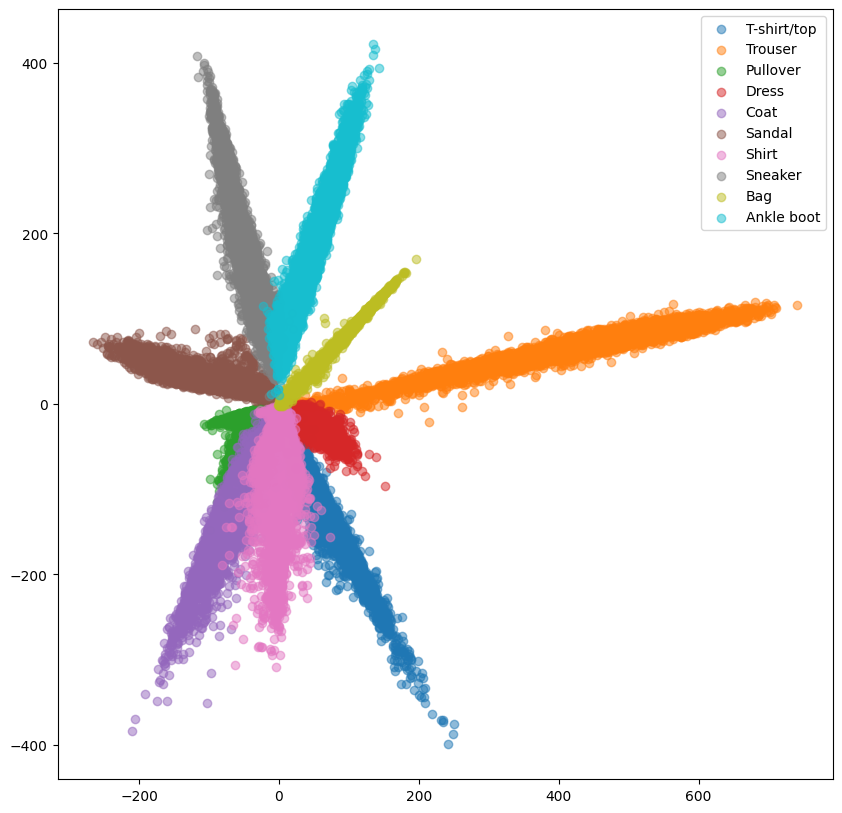

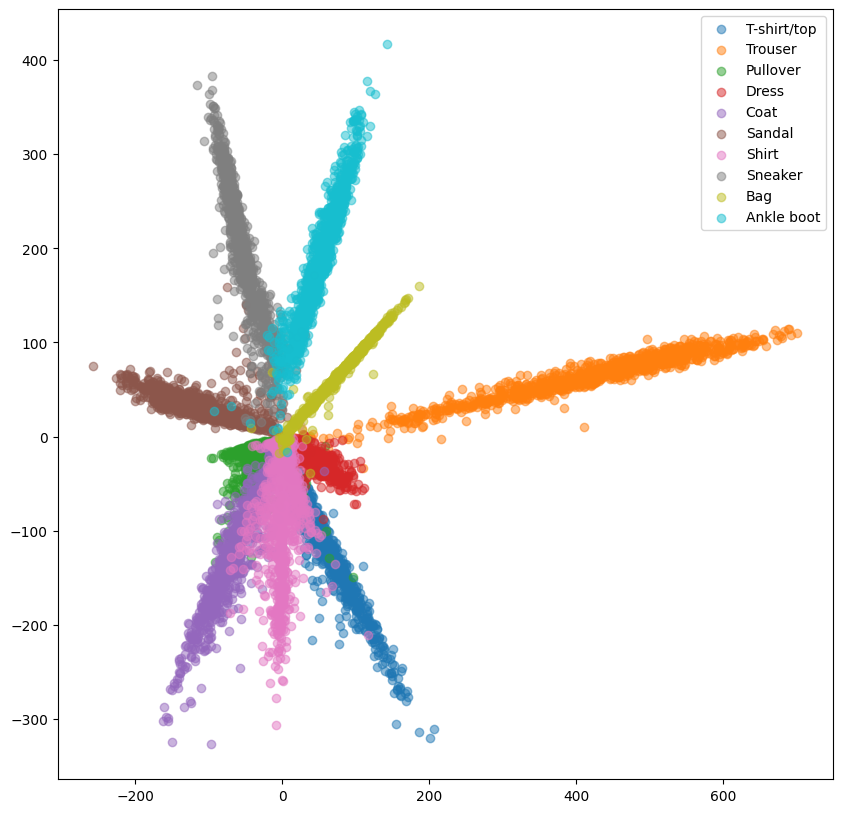

In [7]:
train_embeddings_baseline, train_labels_baseline = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_baseline, train_labels_baseline)
val_embeddings_baseline, val_labels_baseline = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_baseline, val_labels_baseline)

# Siamese network
We'll train a siamese network that takes a pair of images and trains the embeddings so that the distance between them is minimized if their from the same class or greater than some margin value if they represent different classes.
We'll minimize a contrastive loss function*:
$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$

*Raia Hadsell, Sumit Chopra, Yann LeCun, [Dimensionality reduction by learning an invariant mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf), CVPR 2006*

## Steps
1. Create a dataset returning pairs - **SiameseMNIST** class from *datasets.py*, wrapper for MNIST-like classes.
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **siamese** network processing pairs of inputs - **SiameseNet** wrapping *EmbeddingNet*
4. Train the network with **ContrastiveLoss** - *losses.py*

In [8]:
# Set up data loaders
from datasets import SiameseMNIST

# Step 1
siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

# Step 2
embedding_net = EmbeddingNet()
# Step 3
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
    
# Step 4
margin = 1.
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

c:\Users\hwenjun\.conda\envs\deepcosegmentation\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\Users\hwenjun\.conda\envs\deepcosegmentation\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\Users\hwenjun\.conda\envs\deepcosegmentation\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
c:\Users\hwenjun\.conda\envs\deepcosegmentation\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [9]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.271657
Epoch: 1/20. Train set: Average loss: 0.0493
Epoch: 1/20. Validation set: Average loss: 0.0434
Train: [0/60000 (0%)]	Loss: 0.033426
Epoch: 2/20. Train set: Average loss: 0.0372
Epoch: 2/20. Validation set: Average loss: 0.0365
Train: [0/60000 (0%)]	Loss: 0.037862
Epoch: 3/20. Train set: Average loss: 0.0323
Epoch: 3/20. Validation set: Average loss: 0.0332
Train: [0/60000 (0%)]	Loss: 0.028777
Epoch: 4/20. Train set: Average loss: 0.0291
Epoch: 4/20. Validation set: Average loss: 0.0319
Train: [0/60000 (0%)]	Loss: 0.031381
Epoch: 5/20. Train set: Average loss: 0.0269
Epoch: 5/20. Validation set: Average loss: 0.0292
Train: [0/60000 (0%)]	Loss: 0.027024
Epoch: 6/20. Train set: Average loss: 0.0248
Epoch: 6/20. Validation set: Average loss: 0.0295
Train: [0/60000 (0%)]	Loss: 0.038628
Epoch: 7/20. Train set: Average loss: 0.0225
Epoch: 7/20. Validation set: Average loss: 0.0306
Train: [0/60000 (0%)]	Loss: 0.033904
Epoch: 8/20. Train set: Average loss: 0

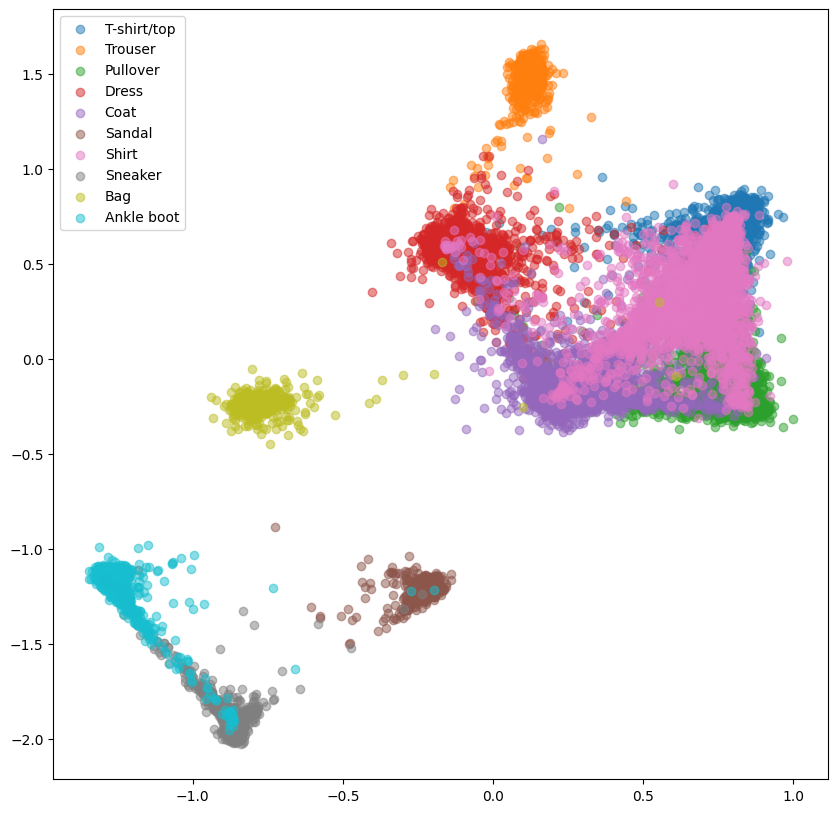

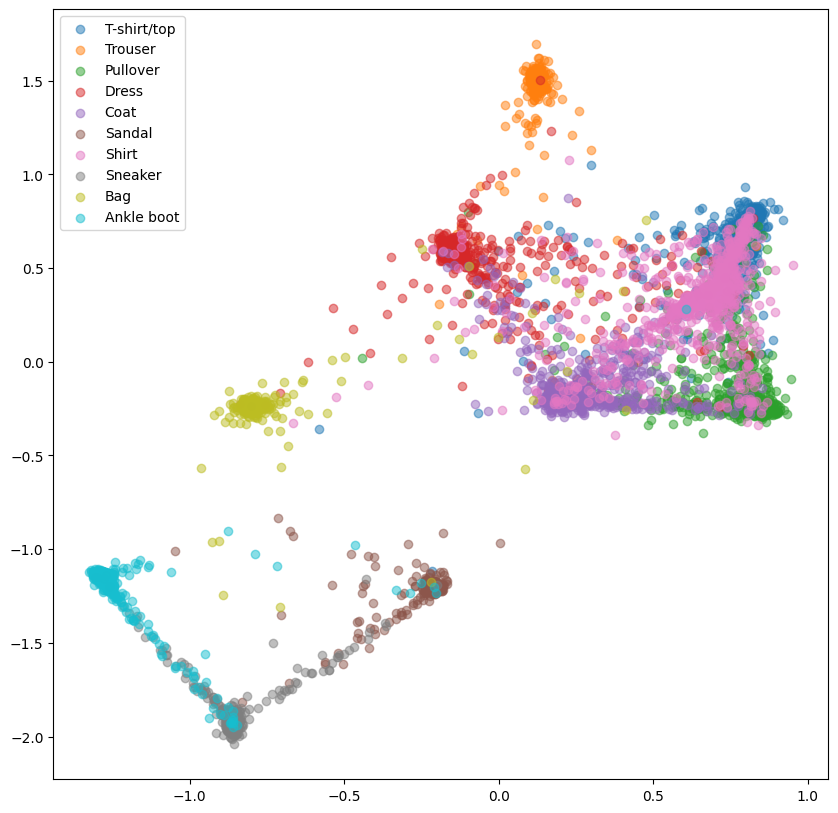

In [10]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

## Steps
1. Create a dataset returning triplets - **TripletMNIST** class from *datasets.py*, wrapper for MNIST-like classes
2. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
3. Define **triplet** network processing triplets - **TripletNet** wrapping *EmbeddingNet*
4. Train the network with **TripletLoss** - *losses.py*

In [11]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 500

In [12]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999791
Epoch: 1/20. Train set: Average loss: 0.2039
Epoch: 1/20. Validation set: Average loss: 0.1549
Train: [0/60000 (0%)]	Loss: 0.202406
Epoch: 2/20. Train set: Average loss: 0.1395
Epoch: 2/20. Validation set: Average loss: 0.1344
Train: [0/60000 (0%)]	Loss: 0.291684
Epoch: 3/20. Train set: Average loss: 0.1150
Epoch: 3/20. Validation set: Average loss: 0.1292
Train: [0/60000 (0%)]	Loss: 0.110744
Epoch: 4/20. Train set: Average loss: 0.1067
Epoch: 4/20. Validation set: Average loss: 0.1212
Train: [0/60000 (0%)]	Loss: 0.067691
Epoch: 5/20. Train set: Average loss: 0.0971
Epoch: 5/20. Validation set: Average loss: 0.1074
Train: [0/60000 (0%)]	Loss: 0.090909
Epoch: 6/20. Train set: Average loss: 0.0869
Epoch: 6/20. Validation set: Average loss: 0.1164
Train: [0/60000 (0%)]	Loss: 0.090507
Epoch: 7/20. Train set: Average loss: 0.0832
Epoch: 7/20. Validation set: Average loss: 0.0981
Train: [0/60000 (0%)]	Loss: 0.057824
Epoch: 8/20. Train set: Average loss: 0

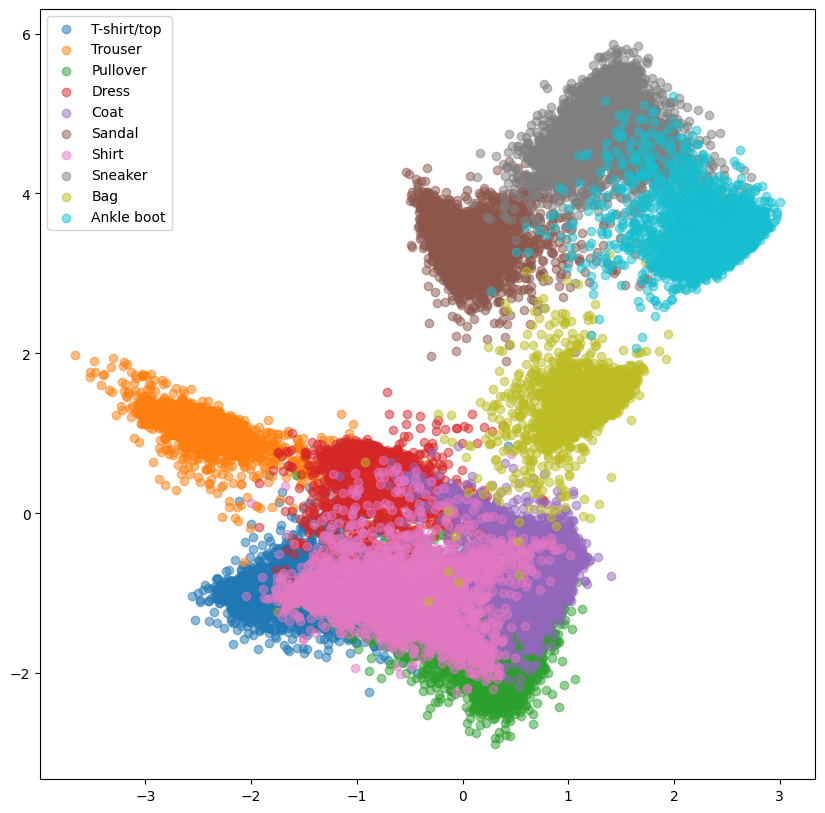

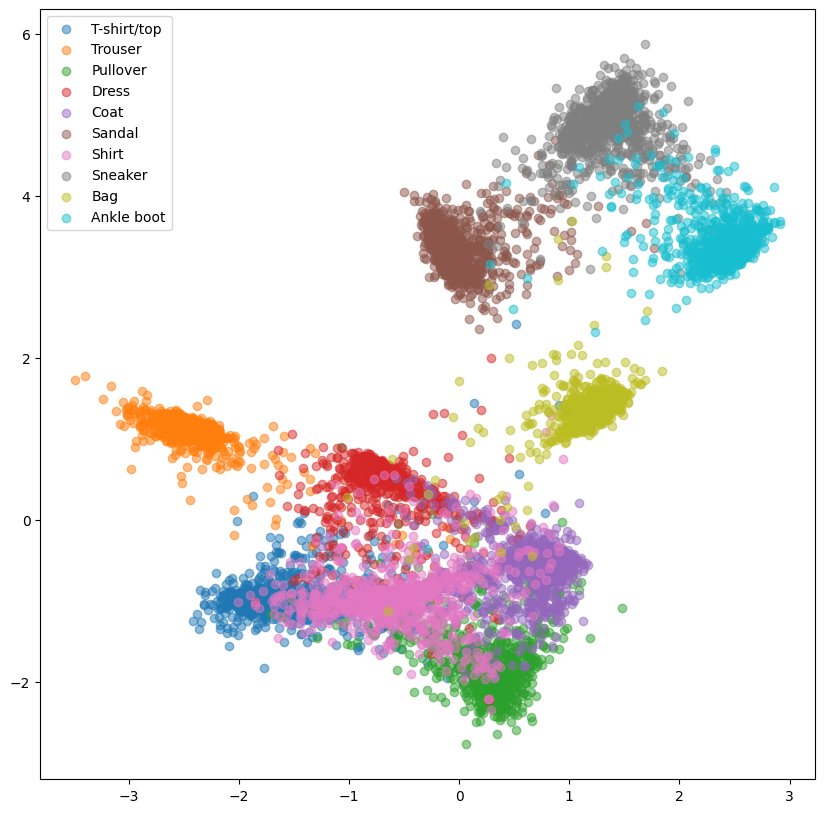

In [13]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online pair selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **PairSelector** that takes embeddings and original labels and returns valid pairs within a minibatch
5. Define **OnlineContrastiveLoss** that will use a *PairSelector* and compute *ContrastiveLoss* on such pairs
6. Train the network!

In [14]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineContrastiveLoss
from utils import AllPositivePairSelector, HardNegativePairSelector # Strategies for selecting pairs within a minibatch

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineContrastiveLoss(margin, HardNegativePairSelector())
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 250

In [15]:
all_embeddings = fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.493686
Epoch: 1/20. Train set: Average loss: 0.2468
Epoch: 1/20. Validation set: Average loss: 0.1854
Train: [0/60000 (0%)]	Loss: 0.210781
Epoch: 2/20. Train set: Average loss: 0.1739
Epoch: 2/20. Validation set: Average loss: 0.1655
Train: [0/60000 (0%)]	Loss: 0.154662
Epoch: 3/20. Train set: Average loss: 0.1479
Epoch: 3/20. Validation set: Average loss: 0.1560
Train: [0/60000 (0%)]	Loss: 0.114940
Epoch: 4/20. Train set: Average loss: 0.1296
Epoch: 4/20. Validation set: Average loss: 0.1518
Train: [0/60000 (0%)]	Loss: 0.142453
Epoch: 5/20. Train set: Average loss: 0.1162
Epoch: 5/20. Validation set: Average loss: 0.1470
Train: [0/60000 (0%)]	Loss: 0.104333
Epoch: 6/20. Train set: Average loss: 0.1038
Epoch: 6/20. Validation set: Average loss: 0.1411
Train: [0/60000 (0%)]	Loss: 0.089840
Epoch: 7/20. Train set: Average loss: 0.0931
Epoch: 7/20. Validation set: Average loss: 0.1402
Train: [0/60000 (0%)]	Loss: 0.098136
Epoch: 8/20. Train set: Average loss: 0

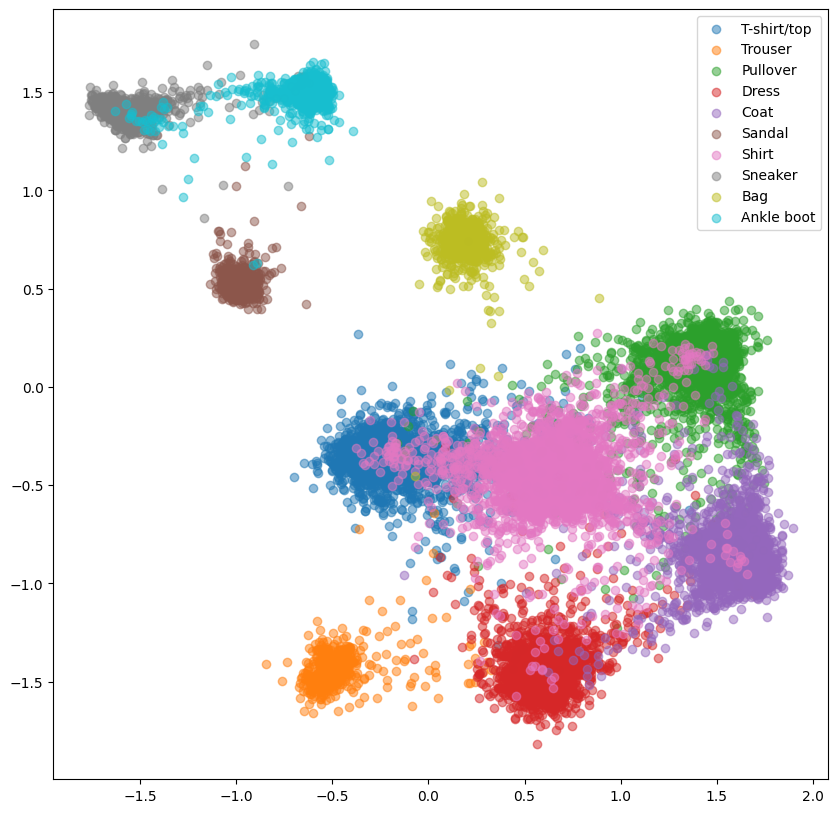

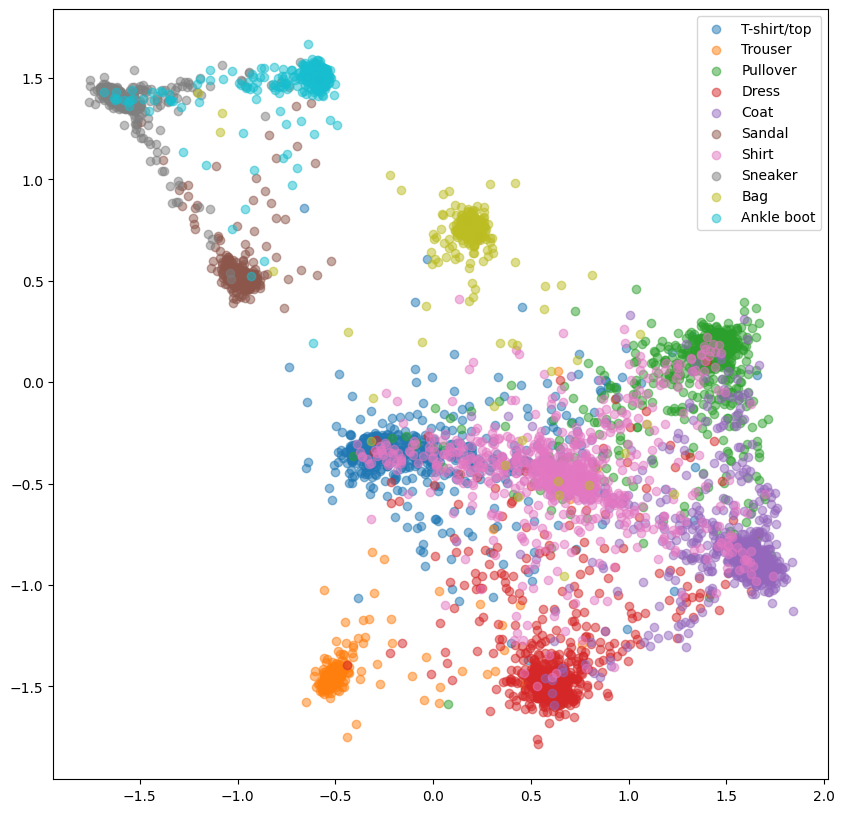

In [16]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_ocl, train_labels_ocl)
val_embeddings_ocl, val_labels_ocl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_ocl, val_labels_ocl)

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [17]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

In [18]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999308	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.996677	Average nonzero triplets: 2501.17880794702
Epoch: 1/20. Train set: Average loss: 0.9985	Average nonzero triplets: 2391.476987447699
Epoch: 1/20. Validation set: Average loss: 0.9101	Average nonzero triplets: 2209.076923076923
Train: [0/60000 (0%)]	Loss: 0.797972	Average nonzero triplets: 2129.0
Train: [37500/60000 (62%)]	Loss: 0.993225	Average nonzero triplets: 2044.6754966887418
Epoch: 2/20. Train set: Average loss: 0.9941	Average nonzero triplets: 2016.175732217573
Epoch: 2/20. Validation set: Average loss: 0.9516	Average nonzero triplets: 2056.6666666666665
Train: [0/60000 (0%)]	Loss: 0.970611	Average nonzero triplets: 1846.0
Train: [37500/60000 (62%)]	Loss: 0.997855	Average nonzero triplets: 1869.708609271523
Epoch: 3/20. Train set: Average loss: 0.9984	Average nonzero triplets: 1860.326359832636
Epoch: 3/20. Validation set: Average loss: 0.9067	Average nonzero triplets: 

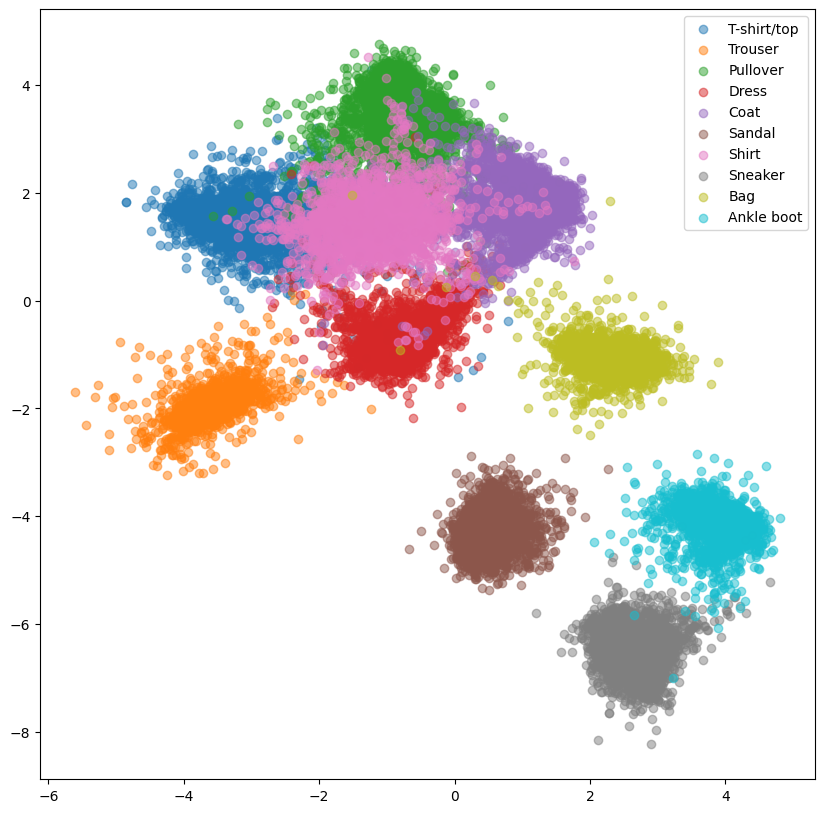

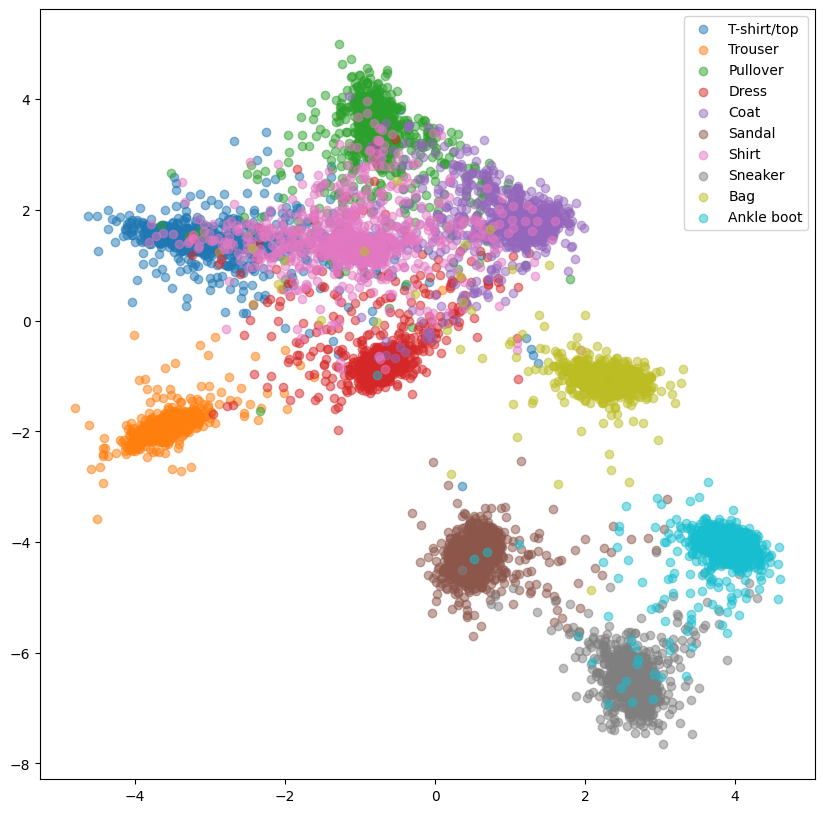

In [19]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

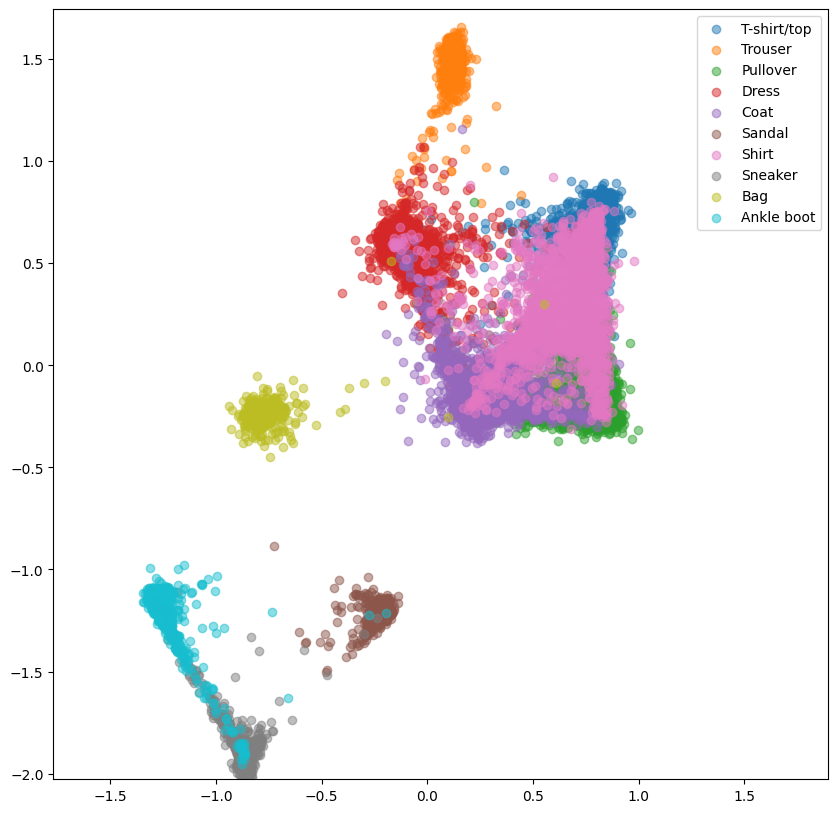

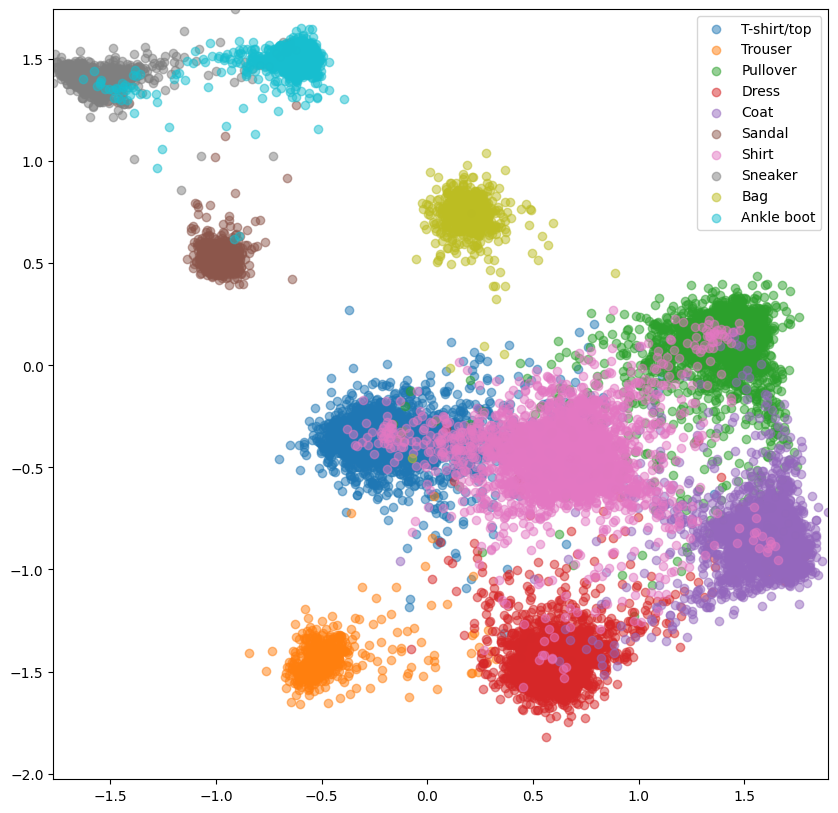

In [20]:
#WJ: compare online contrastive loss vs normal contrastive loss
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_ocl, train_embeddings_cl, train_labels_ocl, train_labels_cl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_ocl, val_embeddings_cl, val_labels_ocl, val_labels_cl

x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))

plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

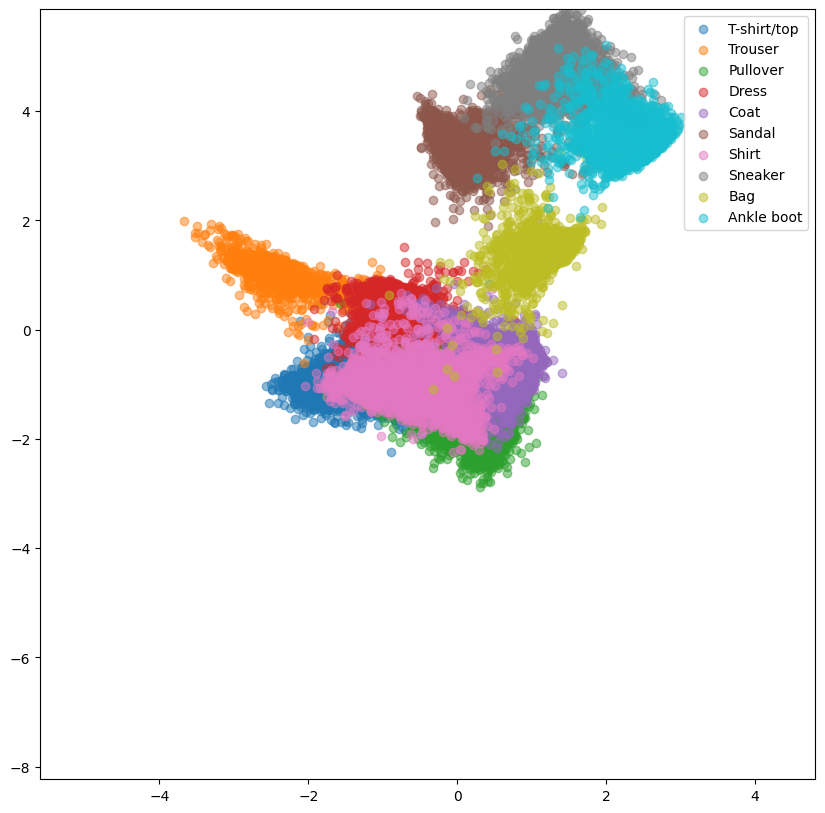

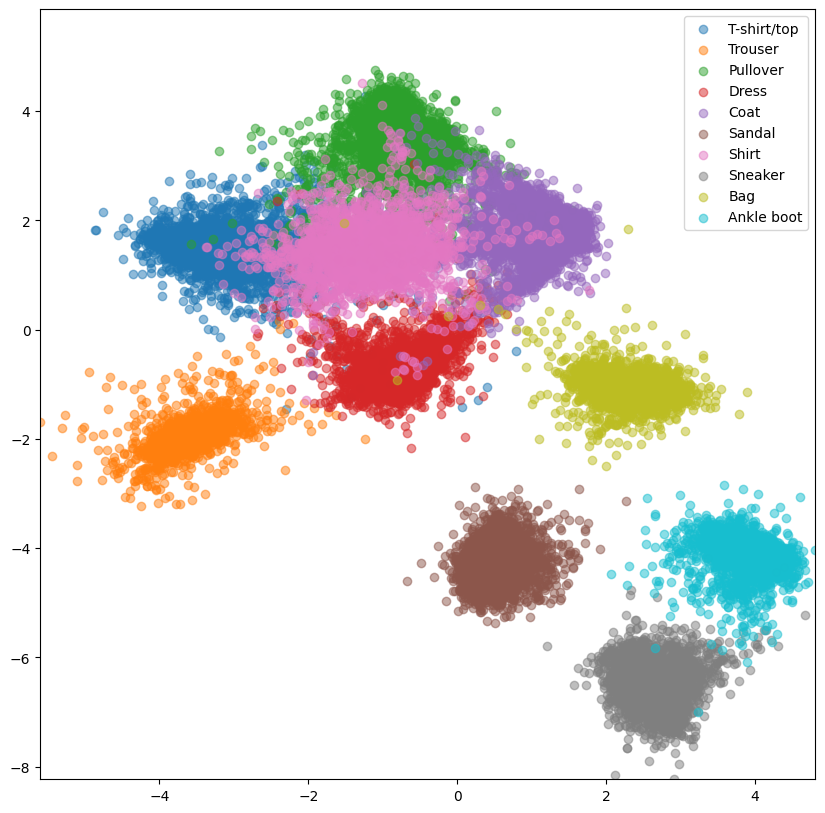

In [21]:
#WJ: compare online triplet loss vs normal triplet loss
display_emb_online, display_emb, display_label_online, display_label = train_embeddings_otl, train_embeddings_tl, train_labels_otl, train_labels_tl
# display_emb_online, display_emb, display_label_online, display_label = val_embeddings_otl, val_embeddings_tl, val_labels_otl, val_labels_tl
x_lim = (np.min(display_emb_online[:,0]), np.max(display_emb_online[:,0]))
y_lim = (np.min(display_emb_online[:,1]), np.max(display_emb_online[:,1]))
x_lim = (min(x_lim[0], np.min(display_emb[:,0])), max(x_lim[1], np.max(display_emb[:,0])))
y_lim = (min(y_lim[0], np.min(display_emb[:,1])), max(y_lim[1], np.max(display_emb[:,1])))
plot_embeddings(display_emb, display_label, x_lim, y_lim)
plot_embeddings(display_emb_online, display_label_online, x_lim, y_lim)

In [11]:
#use pre-trained network
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


from networks import EmbeddingNet_Resnet
import torch
import torchvision
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet_Resnet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 150

fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)


Train: [0/60000 (0%)]	Loss: 3814.739502	Average nonzero triplets: 2974.0
Train: [37500/60000 (62%)]	Loss: 26.674991	Average nonzero triplets: 2320.9867549668875
Epoch: 1/20. Train set: Average loss: 33.1916	Average nonzero triplets: 2307.715481171548
Epoch: 1/20. Validation set: Average loss: 1.2646	Average nonzero triplets: 2250.3076923076924
Train: [0/60000 (0%)]	Loss: 1.271573	Average nonzero triplets: 2380.0
Train: [37500/60000 (62%)]	Loss: 1.183098	Average nonzero triplets: 2193.0066225165565
Epoch: 2/20. Train set: Average loss: 1.1596	Average nonzero triplets: 2160.276150627615
Epoch: 2/20. Validation set: Average loss: 1.1601	Average nonzero triplets: 2106.3846153846152
Train: [0/60000 (0%)]	Loss: 1.216552	Average nonzero triplets: 2171.0
Train: [37500/60000 (62%)]	Loss: 1.087589	Average nonzero triplets: 2031.2185430463576
Epoch: 3/20. Train set: Average loss: 1.0909	Average nonzero triplets: 2025.4602510460252
Epoch: 3/20. Validation set: Average loss: 1.0854	Average nonzero 

KeyboardInterrupt: 